<a href="https://colab.research.google.com/github/EmilSkaaning/MILC_IT_UCPH/blob/main/hackathon/SHAPvalues/Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon in SHAPvalues
Welcome to the first MILC_IT Hackathon!
Pleas make sure to copy this colab to your own drive if you want to change in it.  

File -> Save a copy in drive

In [33]:
!rm -rf MILC_IT_UCPH/ 

We start by cloning the MILC_IT's GitHub to access data, the requirements file and importing the necesarry libraries. 

In [42]:
!git clone https://github.com/EmilSkaaning/MILC_IT_UCPH.git
!pip install -r MILC_IT_UCPH/hackathon/SHAPvalues/requirements.txt

from sklearn.datasets import load_wine
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
import shap
import pandas as pd
import numpy as np
import plotly.graph_objects as go

fatal: destination path 'MILC_IT_UCPH' already exists and is not an empty directory.


# Some functions

In [55]:
def multi_plot(df, title, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list():
        fig.add_trace(
            go.Scatter(
                x = df.index,
                y = df[column],
                name = column
            )
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns.isin(df.columns),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns.isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns.map(lambda column: create_layout_button(column)))
            )
        ],
         yaxis_type="log"       
    )
    # Update remaining layout properties
    fig.update_layout(
        title_text=title,
        height=800,
    )

    fig.show()

# Visualizing the data
Lets start by having a look at the data

In [37]:
# sklearn data to pandas dataframe
# X, y = load_wine(return_X_y=True)
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
print(df.shape)
df.head()

(178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [44]:
!pip install dash

     |████████████████████████████████| 7.4 MB 15.4 MB/s 
     |████████████████████████████████| 357 kB 51.2 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3822 sha256=cee6e1995be3c23c67fe05a1b93007d5a11e088561b4d4d336fe3737185936d5
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4090 sha256=c55f36b3e08694f1963cf08527cadb4fa726383bc896421c55b9a3afe02ab634
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3912 sha256=1a38aad265542050e1799581b646eb202806d1eabf5506dba83f333570b00478
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aefd2e2
Successfully built dash-core-components dash-html-co

In [56]:
multi_plot(df, title="Features across all samples")    

In [57]:
multi_plot(df.T, title="Features per sample")    

# Machine learning
lets do some ML-magic.

First we start by splitting our data into training and test sets.


In [38]:
### Random training/test data split ###
train_idx, test_idx = train_test_split(df.index.tolist(), test_size=0.2, random_state=42)

X_train = []
y_train = []
X_test = []
y_test = []

for idx, row in df.iterrows():
    if idx in train_idx:
        X_train.append(df.iloc[idx][df.columns != 'target'].tolist())
        y_train.append(int(df.iloc[idx]['target']))
    else:
        X_test.append(df.iloc[idx][df.columns != 'target'].tolist())
        y_test.append(int(df.iloc[idx]['target']))

print('----DATA SET----')
print(f'Train \t | \t Test'.expandtabs(0))
print(f'{len(X_train)} \t | \t {len(X_test)}'.expandtabs(2))

----DATA SET----
Train  |  Test
142    |   36


In [39]:
model = RandomForestClassifier()
cv_results = cross_validate(model, X_train, y_train, scoring='roc_auc_ovr', cv=10)
print(f"CV AUC w/o FS: {cv_results['test_score'].mean():.4}")

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=3, step=1)
cv_results = cross_validate(rfe, X_train, y_train, scoring='roc_auc_ovr', cv=10)
print(f"CV AUC w. FS: {cv_results['test_score'].mean():.4}")

CV AUC w/o FS: 0.9969
CV AUC w. FS: 0.9867


In [40]:
model = RandomForestClassifier()
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

i = 1
auc = []
acc = []
mcc = []
best_auc = 0.0
best_acc = 0.0
best_mcc = 0.0
for train_index, val_index in cv_folds.split(X_train, y_train):
    print(f'{i}. CV iteration', end =' '); i += 1

    train_x, valid_x = X_train[train_index], X_train[val_index]
    train_y, valid_y = y_train[train_index], y_train[val_index]

    model.fit(train_x, train_y)

    pred_proba = model.predict_proba(valid_x)
    pred_labels = model.predict(valid_x)

    auc.append(metrics.roc_auc_score(valid_y, pred_proba, multi_class='ovr'))
    acc.append(metrics.accuracy_score(valid_y, pred_labels))
    mcc.append(metrics.matthews_corrcoef(valid_y, pred_labels))
    print(f'Current AUC: {auc[-1]:.4f}, Current Acc: {acc[-1]:.4f}, Current MCC: {mcc[-1]:.4f}')

    if auc[-1] > best_auc:
        best_auc = auc[-1]
        best_model = model

    if acc[-1] > best_acc:
        best_acc = acc[-1]
    
    if mcc[-1] > best_mcc:
        best_mcc = mcc[-1]

print(f'\nMean AUC: {np.mean(auc):.4f} +/- {np.std(auc, ddof=1):.4f}  |  Best AUC: {best_auc:.4f}')
print(f'Mean Acc: {np.mean(acc):.4f} +/- {np.std(acc, ddof=1):.4f}  |  Best Acc: {best_acc:.4f}')
print(f'Mean MCC: {np.mean(mcc):.4f} +/- {np.std(mcc, ddof=1):.4f}  |  Best MCC: {best_mcc:.4f}')

1. CV iteration Current AUC: 1.0000, Current Acc: 1.0000, Current MCC: 1.0000
2. CV iteration Current AUC: 0.9965, Current Acc: 0.9310, Current MCC: 0.8949
3. CV iteration Current AUC: 0.9982, Current Acc: 0.9643, Current MCC: 0.9481
4. CV iteration Current AUC: 1.0000, Current Acc: 0.9643, Current MCC: 0.9481
5. CV iteration Current AUC: 1.0000, Current Acc: 1.0000, Current MCC: 1.0000

Mean AUC: 0.9989 +/- 0.0016  |  Best AUC: 1.0000
Mean Acc: 0.9719 +/- 0.0290  |  Best Acc: 1.0000
Mean MCC: 0.9582 +/- 0.0439  |  Best MCC: 1.0000


In [41]:
print(f'----------------Testing classifier ----------------')
X_test_pca = X_test
Y_pred_proba = best_model.predict_proba(X_test_pca)
print('Pred. AUC:', metrics.roc_auc_score(y_test, Y_pred_proba, multi_class='ovr'))
Y_pred = best_model.predict(X_test_pca)
print('Pred. Acc:', metrics.accuracy_score(y_test, Y_pred))
print('Pred. MCC:', metrics.matthews_corrcoef(y_test, Y_pred))
print('Confusion matrix:', metrics.confusion_matrix(y_test, Y_pred).ravel())
print('Total sites:', len(y_test))

----------------Testing classifier ----------------
Pred. AUC: 1.0
Pred. Acc: 1.0
Pred. MCC: 1.0
Confusion matrix: [14  0  0  0 14  0  0  0  8]
Total sites: 36


# Shap values

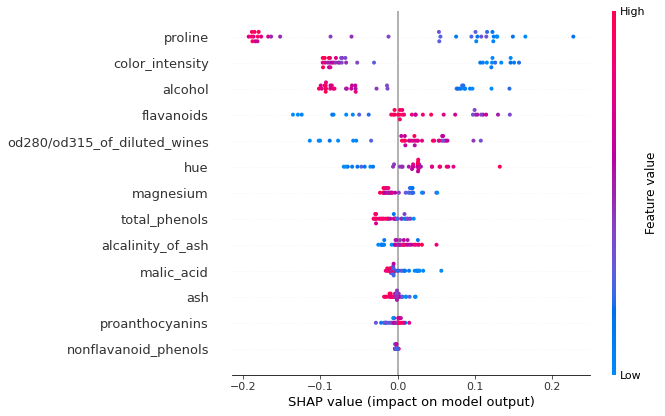

In [68]:
X_test = np.array(X_test)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(best_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test, list(df.columns))

# More reading
https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
